<a href="https://colab.research.google.com/github/ansimhyang60/mini_project/blob/main/%EA%B8%B0%EC%A1%B4%EC%BD%94%EB%93%9C%EC%97%90_skfold_model_cat_%EA%B0%92_%EB%B3%80%EA%B2%BD_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://dacon.io/competitions/official/235713/data

https://dacon.io/codeshare/2477 pycaret

https://dacon.io/competitions/official/235713/codeshare/2768?page=1&dtype=recent 1위

In [ ]:
path = '/content/drive/MyDrive/CSV/'

In [ ]:
import os
os.listdir(path)

['train.csv',
 'test.csv',
 'sample_submission.csv',
 'data-Pension.csv',
 'occyp_null.csv',
 'occyp_full.csv',
 '※ 데이터 변수 설명 ※.gdoc',
 'occyp_type-mean.csv']

In [ ]:
import pandas as pd
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

In [ ]:
print(train.shape)
print(test.shape)
print(submission.shape)

(26457, 20)
(10000, 19)
(10000, 4)


In [ ]:
# !pip install catboost
# !pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [ ]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
train.fillna('NaN', inplace=True)
test.fillna('NaN', inplace=True)

In [ ]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

In [ ]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

In [ ]:
# 무직이고 연금수령자인 사람의 직업유형에 결측치 대체
def fill_pensioner(occup, income_type):
  if (occup == 'NaN') & (income_type == 'Pensioner'):
    occup = 'Pensioner'
    return occup
  else:
    return occup

In [ ]:
train['occyp_type_'] = train[['occyp_type', 'income_type']].apply(lambda x: fill_pensioner(*x), axis=1)
test['occyp_type_'] = train[['occyp_type', 'income_type']].apply(lambda x: fill_pensioner(*x), axis=1)

# 필요한 변수
- Age: 나이
- workable : 근무가능 연수, (나이-20)
- worked : 업무기간. 근무한 년수
- unemployed : 실업기간, (나이-20-근무한 년수)
- 기존 ability : (소득/(나이+업무기간))
- sincerity : 성실성, (소득*업무기간/근무가능연수)
- (아이디어: ability에 근무년수가 많을수록 가중치 줄 수 있게)

## 나이 컬럼 추가

In [ ]:
feats = ['DAYS_BIRTH']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

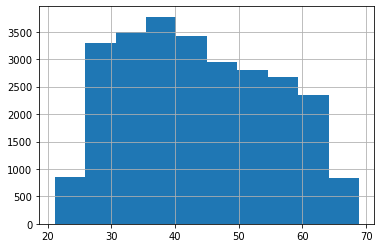

In [ ]:
for df in [train, test]:
  # 나이
  df['Age'] = (df['DAYS_BIRTH'] / 365).round(1)

train['Age'].hist()

In [ ]:
non_occyp_pensioner = train[train.occyp_type_ == 'Pensioner']

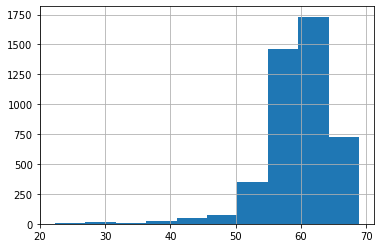

In [ ]:
# 무직 연금수령자의 나이 분포
non_occyp_pensioner.Age.hist()

In [ ]:
# 무직 연금 수령자인데 40세 미만인 사람 수
len(non_occyp_pensioner[non_occyp_pensioner.Age<40])

42

## 업무기간 컬럼 추가

In [ ]:
# 업무기간
for df in [train, test]:
  # 나이
  df['Worked'] = (df['DAYS_EMPLOYED'] / 365).round(1)

train.Worked

0       -12.9
1        -4.2
2       -12.1
3        -5.7
4        -5.8
         ... 
26446    -5.4
26447    -6.8
26448    -5.5
26449    -0.3
26450    -2.8
Name: Worked, Length: 26451, dtype: float64

In [ ]:
np.sum(train.Worked > 0)

4438

In [ ]:
len(non_occyp_pensioner)

4440

In [ ]:
# 모두 연금 수령자임
train[train.Worked>0].occyp_type_.value_counts()

Pensioner    4438
Name: occyp_type_, dtype: int64

In [ ]:
def non_occyp_pensioner_fill_worked(age, worked):
  if worked > 0:
    if (age>=40) & (worked>0):
      worked = 20
    elif worked > 0:
      worked = age-20
  else:
    worked = np.abs(worked)
  return worked

for df in [train, test]:
  df['Worked'] = df[['Age', 'Worked']].apply(lambda x: non_occyp_pensioner_fill_worked(*x), axis=1)

train.Worked

0        12.9
1         4.2
2        12.1
3         5.7
4         5.8
         ... 
26446     5.4
26447     6.8
26448     5.5
26449     0.3
26450     2.8
Name: Worked, Length: 26451, dtype: float64

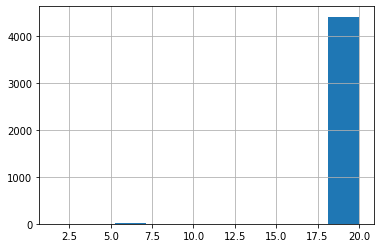

In [ ]:
non_occyp_pensioner = train[train.occyp_type_=='Pensioner']
non_occyp_pensioner.Worked.hist()

## 업무가능 연수, 실업기간 컬럼 추가

In [ ]:
for df in [train, test]:
  df['Workable'] = df['Age'] - 20
  df['Unemployed'] = df['Workable'] - df['Worked']

In [ ]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,occyp_type_,Age,Worked,Workable,Unemployed
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,-4709,0,0,0,NaN,2.0,-6.0,1.0,NaN,38.1,12.9,18.1,5.2
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0,Laborers,31.2,4.2,11.2,7.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,-4434,0,1,0,Managers,2.0,-22.0,2.0,Managers,52.3,12.1,32.3,20.2
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,-2092,0,1,0,Sales staff,2.0,-37.0,0.0,Sales staff,41.3,5.7,21.3,15.6
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,-2105,0,0,0,Managers,2.0,-26.0,2.0,Managers,41.2,5.8,21.2,15.4


## 어빌리티: 1위코드에 있던 변수. (소득/(나이+업무기간))

In [ ]:
for df in [train, test]:
  df['ability'] = ( df['income_total'] / (df['Age']+df['Worked']) ).round(2)

In [ ]:
train.head(2)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,occyp_type_,Age,Worked,Workable,Unemployed,ability
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,-4709,0,0,0,NaN,2.0,-6.0,1.0,NaN,38.1,12.9,18.1,5.2,3970.59
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0,Laborers,31.2,4.2,11.2,7.0,6991.53


## sincerity: 성실성. (소득*업무기간/근무가능연수)

In [ ]:
for df in [train, test]:
  df['sincerity'] = ( df['income_total'] * df['Worked'] / df['Workable'] ).round(2)

In [ ]:
train.head(2)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,occyp_type_,Age,Worked,Workable,Unemployed,ability,sincerity
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,-4709,0,0,0,NaN,2.0,-6.0,1.0,NaN,38.1,12.9,18.1,5.2,3970.59,144323.2
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0,Laborers,31.2,4.2,11.2,7.0,6991.53,92812.5


## 1위 코드에 있었던 변수들(소득/가족수, ID)

In [ ]:
# for df in [train, test]:
#     #income_mean: 소득/ 가족 수
#     df['income_mean'] = df['income_total'] / df['family_size']

#     #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
#     df['ID'] = \
#     df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
#     df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
#     df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
#     df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
#     df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
#     df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
#     df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
#     df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

In [ ]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)


    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])

    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']

    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

In [ ]:
train.head(2)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,occyp_type_,Age,Worked,Workable,Unemployed,ability,sincerity,income_mean,ID
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,-4709,0,0,0,NaN,2.0,-6.0,1.0,NaN,38.1,12.9,18.1,5.2,3970.59,144323.2,101250.0,0_202500.0_13899_-4709_0_0_0_2.0_F_N_N_Commerc...
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0,Laborers,31.2,4.2,11.2,7.0,6991.53,92812.5,82500.0,1_247500.0_11380_-1540_0_0_1_3.0_F_N_Y_Commerc...


## 1위 코드에 있었던 쓸데없어보이는 변수들..은 일단 하지 말자

# 돌려보자!

In [ ]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  16
Number of Categorical features:  10


In [ ]:
numerical_feats

['child_num',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'Age',
 'Worked',
 'Workable',
 'Unemployed',
 'ability',
 'sincerity',
 'income_mean']

In [ ]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'occyp_type_',
 'ID']

In [ ]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [ ]:
# 범주형 변수 제외하고 클러스터링
kmeans_train = train.drop(['credit'], axis=1)
kmeans_train=kmeans_train[numerical_feats]
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test[numerical_feats])

In [ ]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [ ]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,occyp_type_,Age,Worked,Workable,Unemployed,ability,sincerity,income_mean,ID,cluster
0,1,1,1,-0.589850,12.218505,1,1,1,1,-0.490076,-0.463988,-0.538321,-0.645632,-0.316977,1,-0.216262,1.215242,1.0,1,-0.488305,0.465899,-0.488305,-0.988059,0.010513,0.962233,0.002062,1,31
1,1,1,2,0.795036,12.419174,1,2,2,2,-1.089581,-0.440938,-0.538321,-0.645632,3.154805,2,0.897294,1.275633,1.0,2,-1.087676,-0.681544,-1.087676,-0.793769,1.210644,0.237878,-0.254157,2,7
2,2,2,2,-0.589850,13.017007,2,1,1,2,0.744635,-0.461988,-0.538321,1.548870,-0.316977,3,-0.216262,0.248981,2.0,3,0.745184,0.360387,0.745184,0.631024,1.209075,1.303279,1.693108,3,26
3,1,1,2,-0.589850,12.218505,1,2,1,2,-0.207101,-0.444953,-0.538321,1.548870,-0.316977,4,-0.216262,-0.656889,0.0,4,-0.210335,-0.483709,-0.210335,0.134505,0.144758,-0.305238,0.002062,4,18
4,1,2,2,-0.589850,11.967193,3,1,1,2,-0.219239,-0.445048,-0.538321,-0.645632,-0.316977,3,-0.216262,0.007416,2.0,3,-0.219022,-0.470520,-0.219022,0.112917,-0.235609,-0.461336,-0.305401,5,0


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
!pip install svc

  Created wheel for svc: filename=SVC-0.1-py3-none-any.whl size=1891 sha256=e501a0cf4b66f93db83d53ea5333f3cc2aca3161704e7f018b9369cd847cd771
  Stored in directory: /root/.cache/pip/wheels/a8/05/19/97c2a15450caccc712f403b15e6cd5dc32decd32603156aacb
Successfully built svc


## catboost

In [ ]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier(n_estimators=n_est, random_seed=seed)
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=200, verbose=100)

  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.088345
0:	learn: 1.0484003	test: 1.0472646	best: 1.0472646 (0)	total: 121ms	remaining: 4m 1s
100:	learn: 0.7100965	test: 0.6437057	best: 0.6437057 (100)	total: 9.21s	remaining: 2m 53s
200:	learn: 0.6948345	test: 0.6396448	best: 0.6394836 (193)	total: 19.7s	remaining: 2m 55s
300:	learn: 0.6822027	test: 0.6386599	best: 0.6386251 (298)	total: 30.2s	remaining: 2m 50s
400:	learn: 0.6696278	test: 0.6390515	best: 0.6386251 (298)	total: 40.8s	remaining: 2m 42s
500:	learn: 0.6569167	test: 0.6389563	best: 0.6384433 (438)	total: 51.5s	remaining: 2m 34s
600:	learn: 0.6445251	test: 0.6389262	best: 0.6380200 (541)	total: 1m 2s	remaining: 2m 24s
700:	learn: 0.6327446	test: 0.6396775	best: 0.6380200 (541)	total: 1m 12s	remaining: 2m 14s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6380200302
bestIteration = 541

Shrink model to first 542 iterations.
CV Log Loss Score: 0.638020

----------------- Fold 1 --------

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 인위적인 데이터셋을 만듭니다
X, y = make_blobs(random_state=seed)
# 데이터와 타깃 레이블을 훈련 세트와 테스트 세트로 나눕니다
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
# 모델 객체를 만들고 훈련 세트로 학습시킵니다
logreg = LogisticRegression().fit(X_train, y_train)
# 모델을 테스트 세트로 평가합니다
print("테스트 세트 점수: {:.2f}".format(logreg.score(X_test, y_test)))

테스트 세트 점수: 1.00


In [ ]:
def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

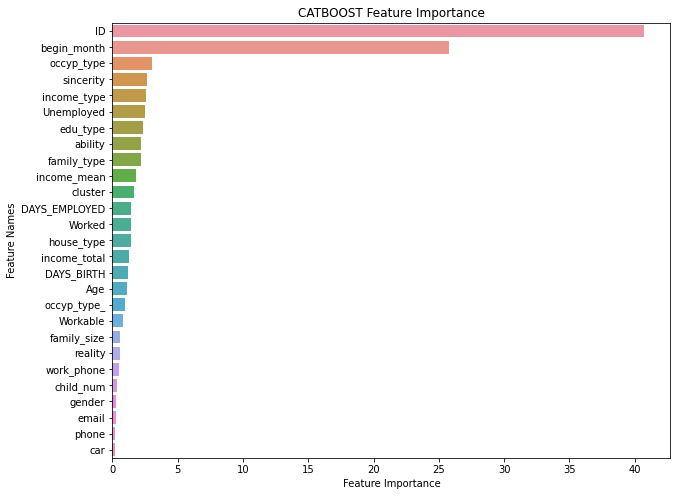

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [ ]:
sub = pd.read_csv(path + 'sample_submission.csv')

In [ ]:
sub.iloc[:, 1:] = cat_pred_test
sub

,index,0,1,2
0,26457,0.097459,0.158771,0.743770
1,26458,0.332133,0.221086,0.446781
2,26459,0.035923,0.064388,0.899689
3,26460,0.053817,0.082501,0.863683
4,26461,0.089118,0.250353,0.660529
...,...,...,...,...
9995,36452,0.076454,0.229787,0.693759
9996,36453,0.326258,0.185588,0.488154
9997,36454,0.043965,0.097644,0.858390
9998,36455,0.134359,0.307196,0.558444


In [ ]:
sub.to_csv('0127_01_submission.csv', index=False)

In [ ]:
# 사용한 df 저장
train.to_csv('0127_01_train.csv')
test.to_csv('0127_01_test.csv')

In [ ]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'credit', 'occyp_type_', 'Age', 'Worked', 'Workable',
       'Unemployed', 'ability', 'sincerity', 'income_mean', 'ID', 'cluster'],
      dtype='object')

# 이하는 원래 코드

In [ ]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

In [ ]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

In [ ]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)


    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])

    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']

    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

In [ ]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [ ]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  32
Number of Categorical features:  1


In [ ]:
numerical_feats

['gender',
 'car',
 'reality',
 'income_total',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'work_phone',
 'phone',
 'email',
 'occyp_type',
 'family_size',
 'begin_month',
 'occyp_type_',
 'Age',
 'Worked',
 'Workable',
 'Unemployed',
 'ability',
 'sincerity',
 'income_mean',
 'cluster',
 'before_EMPLOYED',
 'income_total_befofeEMP_ratio',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'EMPLOYED',
 'DAYS_EMPLOYED_m',
 'DAYS_EMPLOYED_w']

In [ ]:
categorical_feats

['ID']

In [ ]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

In [ ]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [ ]:
# kmeans_train = train.drop(['credit'], axis=1)
# kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
# train['cluster'] = kmeans.predict(kmeans_train)
# test['cluster'] = kmeans.predict(test)

In [ ]:
# 범주형 변수 제외하고 클러스터링
kmeans_train = train.drop(['credit'], axis=1)
kmeans_train=kmeans_train[numerical_feats]
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test[numerical_feats])

In [ ]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [ ]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,credit,occyp_type_,Age,Worked,Workable,Unemployed,ability,sincerity,income_mean,ID,cluster,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_m,before_EMPLOYED_w,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w
0,-0.703501,-0.782418,-1.437631,1.537844,-1.210358,-1.414380,-0.602031,-1.875290,-0.538321,-0.645632,-0.316977,-0.851744,-0.216262,0.695404,1.0,-1.154801,0.0,0.465899,-0.488305,-0.988059,0.019914,0.962233,-0.941908,1,-0.070284,-0.735862,0.349226,0.613195,0.613195,0.0,0.0,0.0,0.0,0.0
1,-0.703501,-0.782418,0.695589,1.540850,-1.210358,0.376342,0.190539,-0.174042,-0.538321,-0.645632,3.154805,-0.576796,0.897294,0.812863,1.0,-0.908344,0.0,-0.681544,-1.087676,-0.793769,-0.110934,0.237878,1.418588,2,-1.215034,0.270949,0.009380,0.613195,0.613195,0.0,0.0,0.0,0.0,0.0
2,1.421462,1.278089,0.695589,1.549515,-0.188227,-1.414380,-0.602031,-0.174042,-0.538321,1.548870,-0.316977,-0.301849,-0.216262,-1.183950,2.0,-0.661887,0.0,0.360387,0.745184,0.631024,-0.036381,1.303279,-1.065816,3,0.105832,-0.320948,0.029737,0.613195,0.613195,0.0,0.0,0.0,0.0,0.0
3,-0.703501,-0.782418,0.695589,1.537844,-1.210358,0.376342,-0.602031,-0.174042,-0.538321,1.548870,-0.316977,-0.026901,-0.216262,-0.390579,0.0,-0.415430,0.0,-0.483709,-0.210335,0.134505,0.185317,-0.305238,-0.941908,4,-0.334457,-1.162711,-0.043968,-1.630803,-1.630803,0.0,0.0,0.0,0.0,0.0
4,-0.703501,1.278089,0.695589,1.534005,0.833903,-1.414380,-0.602031,-0.174042,-0.538321,-0.645632,-0.316977,-0.301849,-0.216262,-1.653788,2.0,-0.661887,0.0,-0.470520,-0.219022,0.112917,0.165146,-0.461336,-0.902910,5,-0.334457,-1.143235,-0.045199,-1.630803,-1.630803,0.0,0.0,0.0,0.0,0.0


모델링

In [ ]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)

  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346887	test: 1.0340177	best: 1.0340177 (0)	total: 113ms	remaining: 1m 52s
100:	learn: 0.7046183	test: 0.6729576	best: 0.6729576 (100)	total: 9.51s	remaining: 1m 24s


KeyboardInterrupt: ignored

In [ ]:
def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [ ]:
sub = pd.read_csv(path + 'sample_submission.csv')

In [ ]:
sub.iloc[:, 1:] = cat_pred_test
sub

In [ ]:
sub.to_csv('submission_1위코드.csv', index=False)